In [2]:
from rur import uri, uhmi
from rur.sci import photometry

import numpy as np
from tqdm import tqdm

import time
from tree_utool import *

In [4]:
modes = ['y07206', 'y05420']
mode = modes[0]

repo, rurmode, dp = mode2repo(mode)
nout = load_nout(mode=mode, galaxy=True)
nstep = load_nstep(mode=mode, galaxy=True, nout=nout)
iout = nout[0]
snap = uri.RamsesSnapshot(repo, iout, mode=rurmode)
gals = uhmi.HaloMaker.load(snap, galaxy=True, double_precision=dp)
print(len(gals))

path = f"/home/jeon/YoungTree/result/backup/{mode}"
file_list = os.listdir(path)
file_list = [file for file in file_list if (file.startswith(f"Progenitor_Branch") & file.endswith(".pickle"))]
print(len(file_list))

Age of the universe (now/z=0): 13.741 / 13.741 Gyr, z = -0.00000 (a = 1.0000)
248
248


In [5]:
assert len(gals)==len(file_list)

In [6]:
dtype = [("rootid", int), ("rootiout", int), ("id", int), ("timestep", int), ("score", float), ("elapsed", float)]
first = True
for gal in gals:
    readme, root, elap, branch, scores = pklload(f'/home/jeon/YoungTree/result/{mode}/Progenitor_Branch_ID{gal["id"]:05d}_iout{iout:05d}.pickle')

    outs = list( branch.keys() )
    ntree = len(outs)
    rootids = np.full(ntree, root['id'], dtype=int)
    rootiouts = np.full(ntree, root['timestep'], dtype=int)
    elapseds = np.full(ntree, elap, dtype=float)
    
    ids = np.array( [branch[ith]['id'] for ith in outs] )
    timesteps = np.array( [branch[ith]['timestep'] for ith in outs] )
    scores = np.array( [scores[ith] for ith in outs] )
    if first:
        result = np.rec.fromarrays((rootids, rootiouts, ids, timesteps, scores, elapseds), dtype=dtype)
        first = False
    else:
        result = np.hstack((result, np.rec.fromarrays((rootids, rootiouts, ids, timesteps, scores, elapseds), dtype=dtype)))
print(len(result))

186241


In [8]:
if not os.path.isdir(f"{repo}/YoungTree"):
    os.mkdir(f"{repo}/YoungTree")
readme = "README:\n    1) Root galaxy ID\n    2) Root galaxy iout\n    3) Galaxy ID\n    4) Galaxy iout\n    5) Score\n    6) Elapsed computing time"
pklsave((readme, result), f"{repo}/YoungTree/ytree.pickle")

In [13]:
import matplotlib.pyplot as plt

In [48]:
gals.dtype

dtype((numpy.record, [('nparts', '<i4'), ('id', '<i4'), ('timestep', '<i4'), ('level', '<i4'), ('host', '<i4'), ('hostsub', '<i4'), ('nbsub', '<i4'), ('nextsub', '<i4'), ('aexp', '<f4'), ('m', '<f4'), ('x', '<f4'), ('y', '<f4'), ('z', '<f4'), ('vx', '<f4'), ('vy', '<f4'), ('vz', '<f4'), ('Lx', '<f4'), ('Ly', '<f4'), ('Lz', '<f4'), ('r', '<f4'), ('a', '<f4'), ('b', '<f4'), ('c', '<f4'), ('ek', '<f4'), ('ep', '<f4'), ('et', '<f4'), ('spin', '<f4'), ('sigma', '<f4'), ('sigma_bulge', '<f4'), ('m_bulge', '<f4'), ('rvir', '<f4'), ('mvir', '<f4'), ('tvir', '<f4'), ('cvel', '<f4'), ('rho0', '<f4'), ('rc', '<f4')]))

Text(0.5, 0, 'log Nparts')

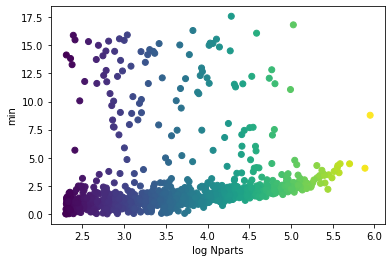

In [59]:
ids, ind = np.unique(result['rootid'], return_index=True)

elaps = result['elapsed'][ind]

plt.scatter(np.log10(gals['nparts'][1:]), elaps[1:]/60, c=np.log10(gals['m'][1:]))
plt.ylabel("min")
plt.xlabel("log Nparts")

In [387]:
from importlib import reload
reload(jn)

Module JEON(220503.0) loading success


<module 'jeonpkg.jeon' from '/home/jeon/jeonpkg/jeon.py'>

In [82]:
treemaker = uhmi.TreeMaker.load(snap, galaxy=True)

Reading /storage3/Clusters/05420/GalaxyMaker/gal/tree.dat... 
 Number of steps found:         168
 Total number of halos:      317028
Progress: >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> - Done!
Took 1.262s
Building table for 19 nodes... Took 0.233s


In [388]:
try:
    from jeonpkg import jeon as jn
except:
    import jeon as jn
galtm = jn.treemaker(galaxy=True, tm=treemaker, mode=mode)

Tree building...
Tree building done (0.01 sec)


In [389]:
def findgal(gid, iout, tree, ioutmax=187):
    istepmax = np.max(tree['timestep'])
    offset = ioutmax - istepmax
    itree = tree[tree['timestep'] == iout-offset]
    return itree[gid-1]

def findgal2(gid, iout, tree):
    return tree.loadgals(iout, gid, useiout=True)


In [390]:
def findfat1s(gid, iout, tree, ioutmax=187):
    igal = findgal2(gid, iout, tree)
    branchs = np.atleast_1d(igal)
    fat1 = igal['fat1']
    if fat1 <= 0:
            fat1 = igal['fat2']
    while fat1>0:
        iout -= 1
        igal = findgal2(fat1, iout, tree)
        branchs = np.hstack((branchs, igal))
        fat1 = igal['fat1']
        if fat1 <= 0:
            fat1 = igal['fat2']
    return branchs

In [391]:
def acorr(arr, aexp):
    return aexp*(arr-0.5) + 0.5


Text(0.5, 0.98, 'Root ID: 1277')

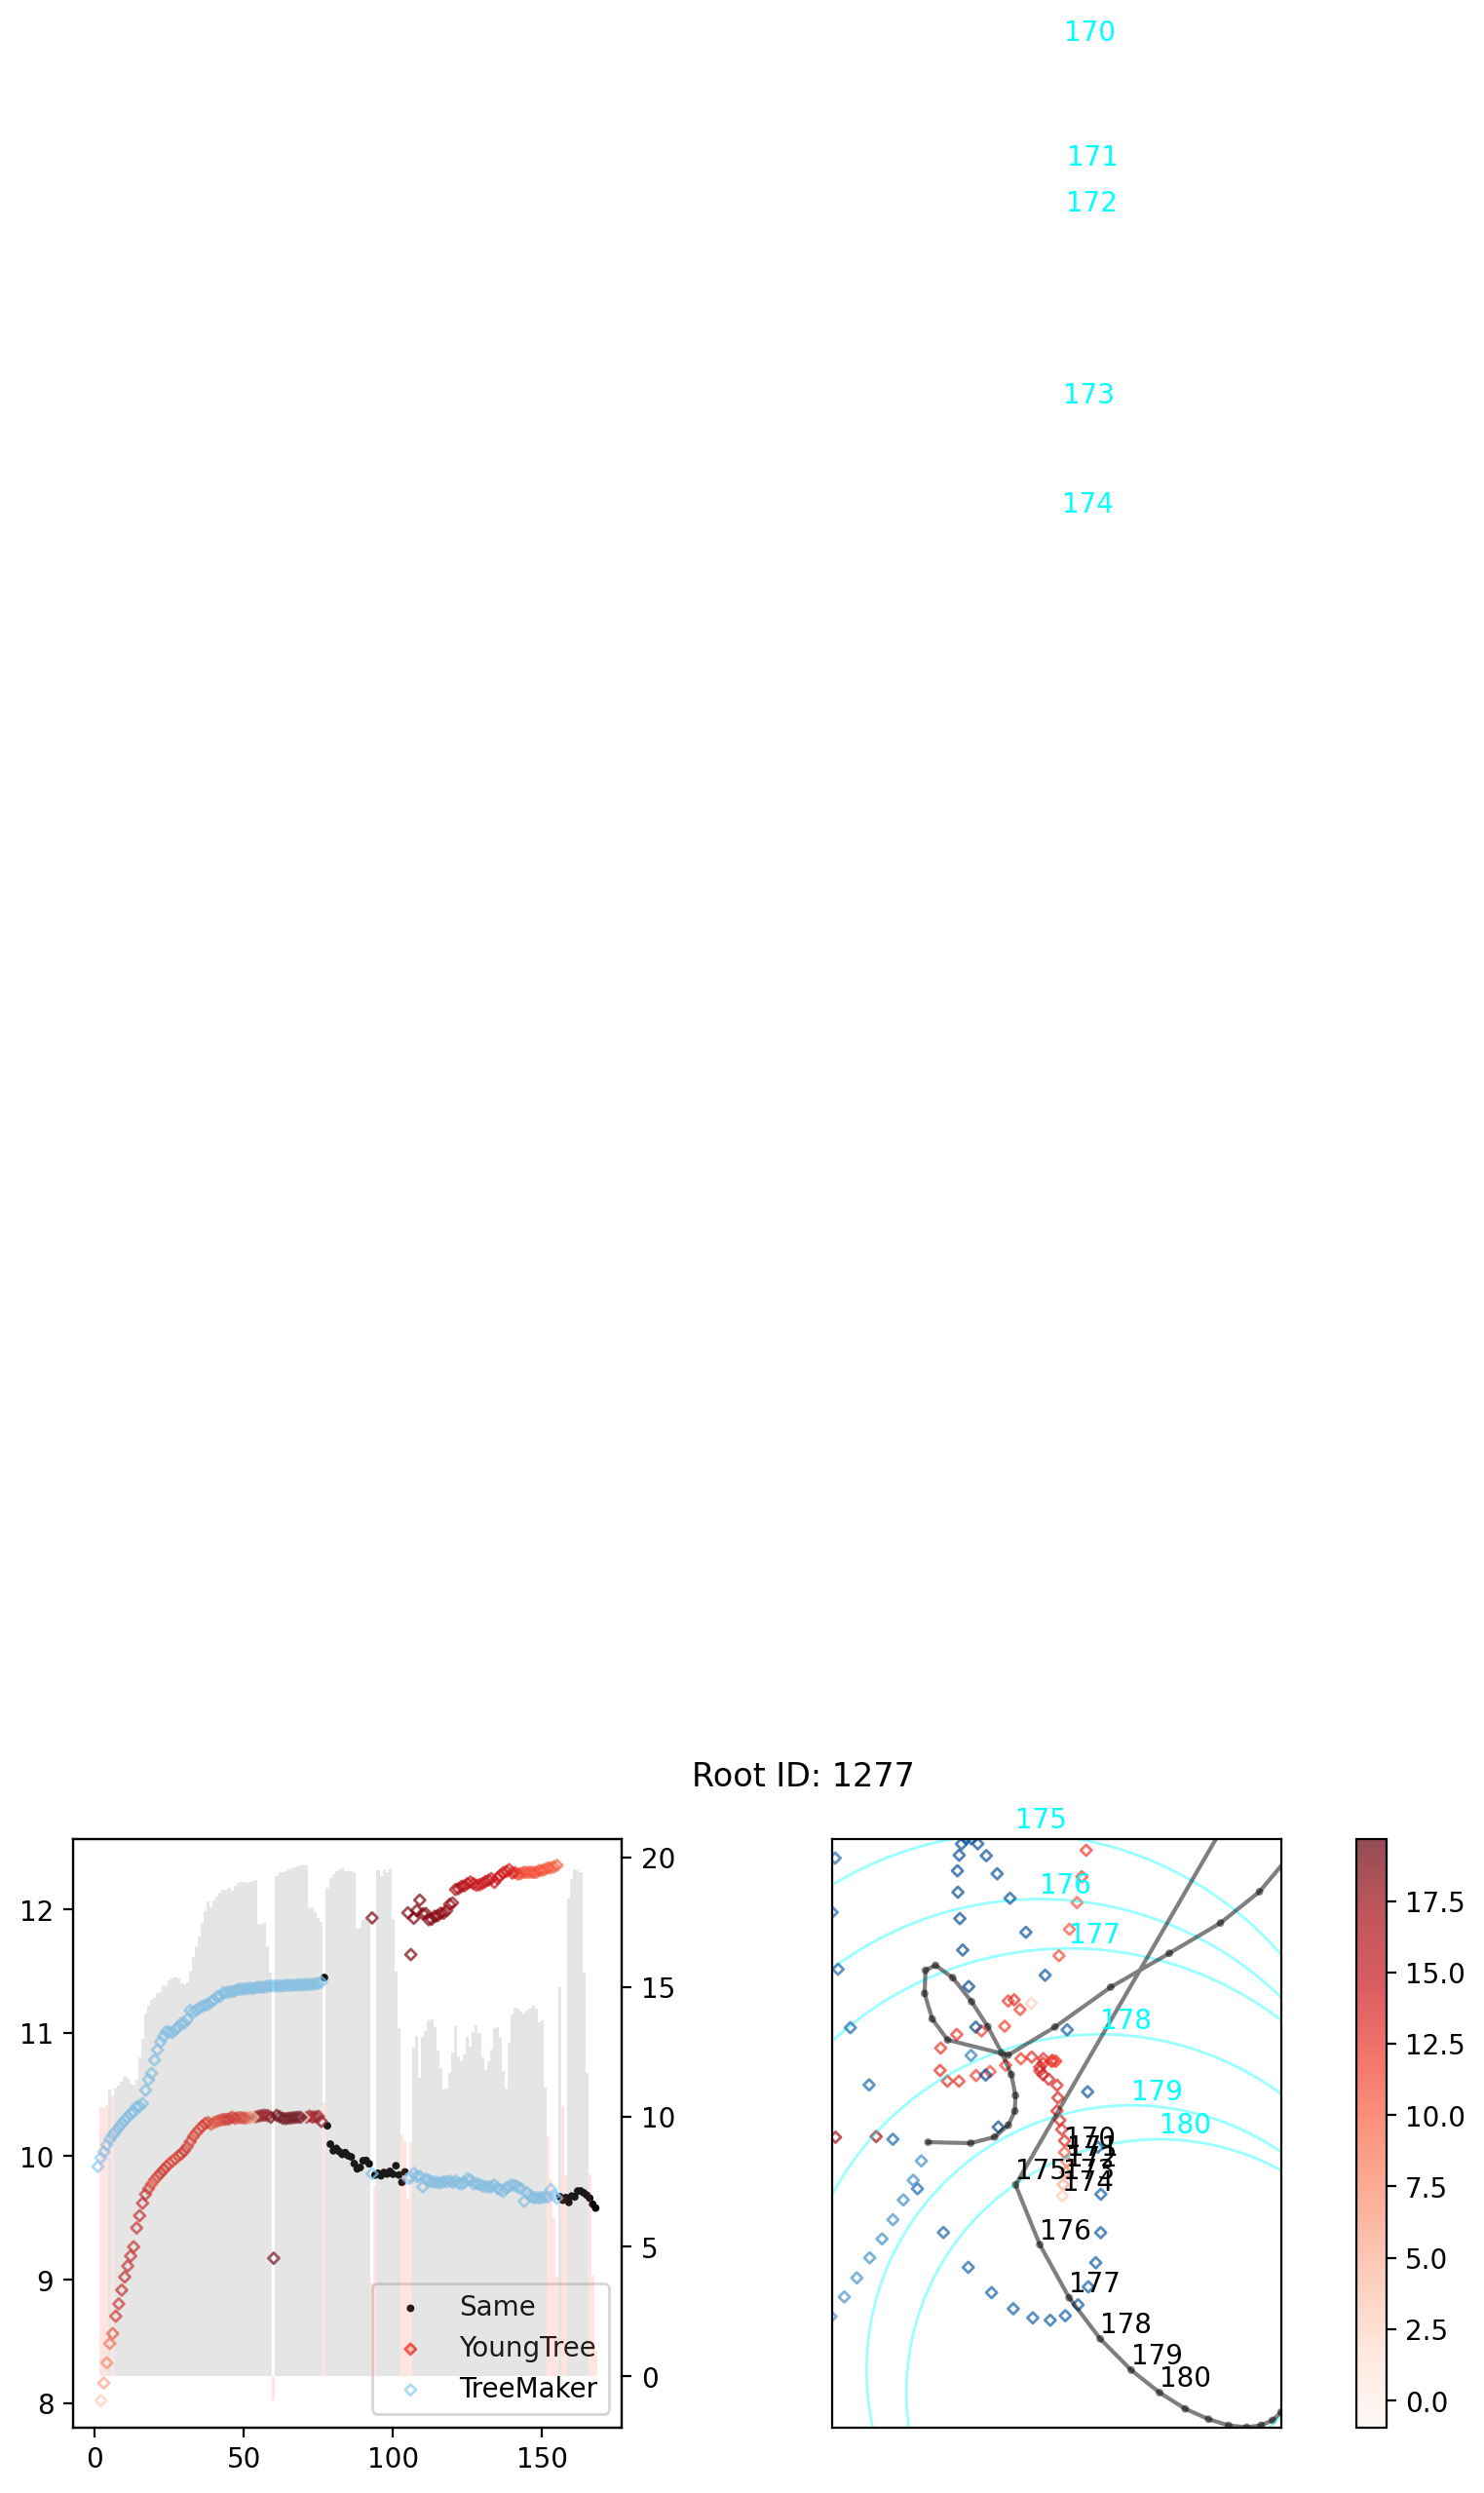

In [412]:
# ini = np.random.choice(len(gals),replace=False)+1
ini = 1277
ind = result['rootid']==ini
branch = result[ind]
for i, ib in enumerate(branch):
    igal = findgal2(ib['id'], ib['timestep'], galtm)
    if i==0:
        branchs = np.atleast_1d(igal)
    else:
        branchs = np.hstack((branchs, igal))        
fat1s = findfat1s(ini, 187, galtm)


from matplotlib.colors import Normalize

fig, axes = plt.subplots(ncols=2, figsize=(10,4))
fig.set_dpi(200)
ax = axes[0]
# ax.scatter(branchs['timestep'], np.log10(branchs['m']), facecolor='magenta', label='YoungTree', edgecolors='none')
ind1 = np.isin(  branchs['id']*1000 + branchs['timestep'] , fat1s['id']*1000 + fat1s['timestep'] )
ind2 = np.isin(  fat1s['id']*1000 + fat1s['timestep'] , branchs['id']*1000 + branchs['timestep'] )
ax.scatter(branchs[ind1]['timestep'], np.log10(branchs[ind1]['m']), facecolor='black', edgecolor='none', label='Same', marker='o', s=8)
if False in ind1:
    sc = ax.scatter(branchs[~ind1]['timestep'], np.log10(branchs[~ind1]['m']), c=branch[~ind1]['score'], label='YoungTree', cmap='Reds', marker='D', s=8, alpha=0.7)
    norm = Normalize(0, 20)
    colors = sc.get_cmap()(norm(branch[~ind1]['score'][::-1]))
    sc.set_facecolor('none')
    sc.set_edgecolors(colors)
if False in ind2:
    ax.scatter(fat1s[~ind2]['timestep'], np.log10(fat1s[~ind2]['m']), marker='D', alpha=0.7, s=8, edgecolor='lightskyblue',facecolor='none', label='TreeMaker')
lg = ax.legend()
if False in ind1:
    lg.legendHandles[1].set_color('red')

ax2 = ax.twinx()
ind = branch['score']>11
ax2.bar(branchs['timestep'][ind], branch['score'][ind], alpha=0.2, color='grey', zorder=-1, width=1)
if False in ind:
    ax2.bar(branchs['timestep'][~ind], branch['score'][~ind], alpha=0.2, color='salmon', zorder=-1, width=1)

ax = axes[1]
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

sc = ax.scatter(branchs[ind1]['x'][::-1], branchs[ind1]['y'][::-1], facecolor='black', edgecolor='none', label='Same', marker='o', s=8, alpha=0.5)
sc = ax.plot(branchs[ind1]['x'][::-1], branchs[ind1]['y'][::-1], color='black', alpha=0.5)
if False in ind1:
    sc = ax.scatter(branchs[~ind1]['x'][::-1], branchs[~ind1]['y'][::-1], c=branch[~ind1]['score'][::-1], zorder=1, cmap='Reds', edgecolors='none', marker='D', alpha=0.7, s=8)
    norm = Normalize(0, 20)
    colors = sc.get_cmap()(norm(branch[~ind1]['score'][::-1]))
    sc.set_facecolor('none')
    sc.set_edgecolors(colors)
    fig.colorbar(sc, ax=axes)
if False in ind2:
    sc2 = ax.scatter(fat1s[~ind2]['x'], fat1s[~ind2]['y'], c=fat1s[~ind2]['timestep'], cmap='Blues', vmin=-100, alpha=0.7, zorder=1.5, s=8, marker='D')
    norm = Normalize(-100, 180)
    colors = sc2.get_cmap()(norm(fat1s[~ind2]['timestep']))
    sc2.set_facecolor('none')
    sc2.set_edgecolors(colors)

ax.set_aspect(1)
x1,x2 = ax.get_xlim()
y1,y2 = ax.get_ylim()
name = 'Mpc'
if x2-x1 < snap.unit['Mpc']:
    name = 'kpc'
lmpc = x2-x1 / snap.unit[name]
ref = int( 10**np.floor(np.log10(lmpc)))
lcode = ref * snap.unit[name]
dx = x2-x1
dy = y2-y1

x2 = x2 - 0.05*dx
x1 = x2-lcode
# ax.plot([x1,x2], [y1+0.05*dy, y1+0.05*dy], color='k', lw=2)
# ax.text(0.5*(x1 + x2), 0.5*(y1+0.06*dy + y1+0.06*dy), f"{ref} {name}", ha='center', va='bottom', color='k')
# print(fat1s['id'][187-175-12 : 187-175+12])


minth = min(170, 187-175+40)
maxth = max(0, 187-175-40)

x1 = np.min(fat1s['x'][maxth:minth])
x2 = np.max(fat1s['x'][maxth:minth])
ax.set_xlim(x1,x2)
y1 = np.min(fat1s['y'][maxth:minth])
y2 = np.max(fat1s['y'][maxth:minth])
ax.set_ylim(y1,y2)


outs = np.arange(175 + 5, 175-5-1, -1)
# print(outs)
# # print(branchs['timestep'])
# uri.timer.verbose=0
for jout in outs:
#     # print(jout)
    jsnap = uri.RamsesSnapshot(repo, jout, mode=rurmode)
    ksnap = uri.RamsesSnapshot(repo, jout-1, mode=rurmode)
    dt = np.abs( ksnap.params['age'] - jsnap.params['age'] )
    dt *= 1e9 * 365 * 24 * 60 * 60 # Gyr to sec
    jstep = jout - 19
    jgal = branchs[168-jstep]
#     jx, jy, jz = jgal['x'],jgal['y'],jgal['y']
#     # print(jx, jy, jz)
#     jx -= 0.5; jy -= 0.5; jz -= 0.5
#     jx *= jgal['aexp']; jy *= jgal['aexp']; jz *= jgal['aexp']
#     jx += 0.5; jy += 0.5; jz += 0.5
#     # print(jx, jy, jz)
#     kgal = branchs[168-jstep+1]
#     kx, ky, kz = kgal['x'],kgal['y'],kgal['y']
#     kx -= 0.5; ky -= 0.5; kz -= 0.5
#     kx *= kgal['aexp']; ky *= kgal['aexp']; kz *= kgal['aexp']
#     kx += 0.5; ky += 0.5; kz += 0.5
#     dist = jn.distance(jx,jy,jz,kx,ky,kz)
    jvel = rms(jgal['vx'], jgal['vy'], jgal['vz'])
#     # print(dt*jvel*jsnap.unit['km'], dist, jn.distance(jgal, kgal))
#     # print(dt*jvel*jsnap.unit['km']/jgal['aexp'], dist, jn.distance(jgal, kgal))
    radii = 5*max(jgal['r'],1e-4) + 5*dt*jvel*jsnap.unit['km']
    # cir = plt.Circle((jgal['x'], jgal['y']), radii, facecolor='none', edgecolor='black', alpha=0.4)
    # ax.add_artist(cir)
    # radii = 5*dt*jvel*jsnap.unit['km']
    cir = plt.Circle((jgal['x'], jgal['y']), radii, facecolor='none', edgecolor='cyan', alpha=0.4)
    ax.add_artist(cir)
    # ax.text(jgal['x'], jgal['y'], f"{jgal['timestep']+19} ({dt*jvel*jsnap.unit['km']/dist})", ha='left', va='bottom')
    ax.text(jgal['x'], jgal['y']+radii, f"{jgal['timestep']+19}", ha='left', va='bottom', color='cyan')
    ax.text(jgal['x'], jgal['y'], f"{jgal['timestep']+19}", ha='left', va='bottom')
#     # print()

fig.suptitle(f"Root ID: {ini}")


In [393]:
target = galtm.loadgals(20, 1, useiout=True)
print(target)
print(target['id'], target['timestep'], target['m'])
print( target['x'], target['y'], target['z'] )
print( target['vx'], target['vy'], target['vz'] )
print(target['son1'])
trees = galtm.loadtree(20, useiout=True)
jn.minmax(trees['x']+0.5)

(1, 1, 1, 1, 0, 0, -1, 1, 0, -1, -1, -1, -1, 2, 1, 703, -1, -1, -1, 0.165, 1.1866837, 5.566424e+09, 0.05275604, 0.360954, 0.29353902, 0.27426824, 139.08185, -63.77087, 81.91299, -0.00266782, 0.00263397, 0.00385928, 2.4424524e-05, 0.0014793, 0.00080123, 0.00125997, 746.34393, -340.6758, 405.66812, 0.3446614, 100., 0., 0., 0., 0., 2.1273141e-05, 5.566424e+09, 142216.92, 62.94024, 20067.79, 2.1273141e-05)
1 1 5566424000.0
0.360954 0.29353902 0.27426824
139.08185 -63.77087 81.91299
1
None : length600 | min0.8008618354797363 | max0.9471160769462585 | mean0.8796293139457703


(600, 0.80086184, 0.9471161, 0.8796293)

In [394]:
snap.params['aexp'], snap.params['age']

(1.00000000568342, 13.741313851027979)

0.165000007564816
46.875002606859084


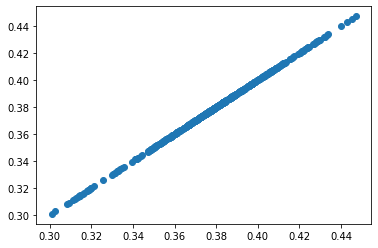

In [395]:
aout20 = 20
snap20 = uri.RamsesSnapshot(repo, aout20, mode=rurmode)
gals20 = uhmi.HaloMaker.load(snap20, galaxy=True)
aexp20 = snap20.params['aexp']
print(aexp20)
boxsize_physical = snap20.params['boxsize_physical']
print(boxsize_physical)

# tgals20 = galtm.loadtree(20, useiout=True)
tgals20 = treemaker[treemaker['timestep'] == 20 - 19]
# array['x'] / boxsize_physical / array['aexp'] + 0.5
# plt.scatter(gals20['x'], galtm.loadtree(20, useiout=True)['x'] / boxsize_physical + 0.5)
# plt.scatter(gals20['x'], (tgals20['x']-0.5)*boxsize_physical*aexp20)
plt.scatter(gals20['x'], tgals20['x'])


0.00044608114461046306
0.0005158658783028871 0.0016713577216471793


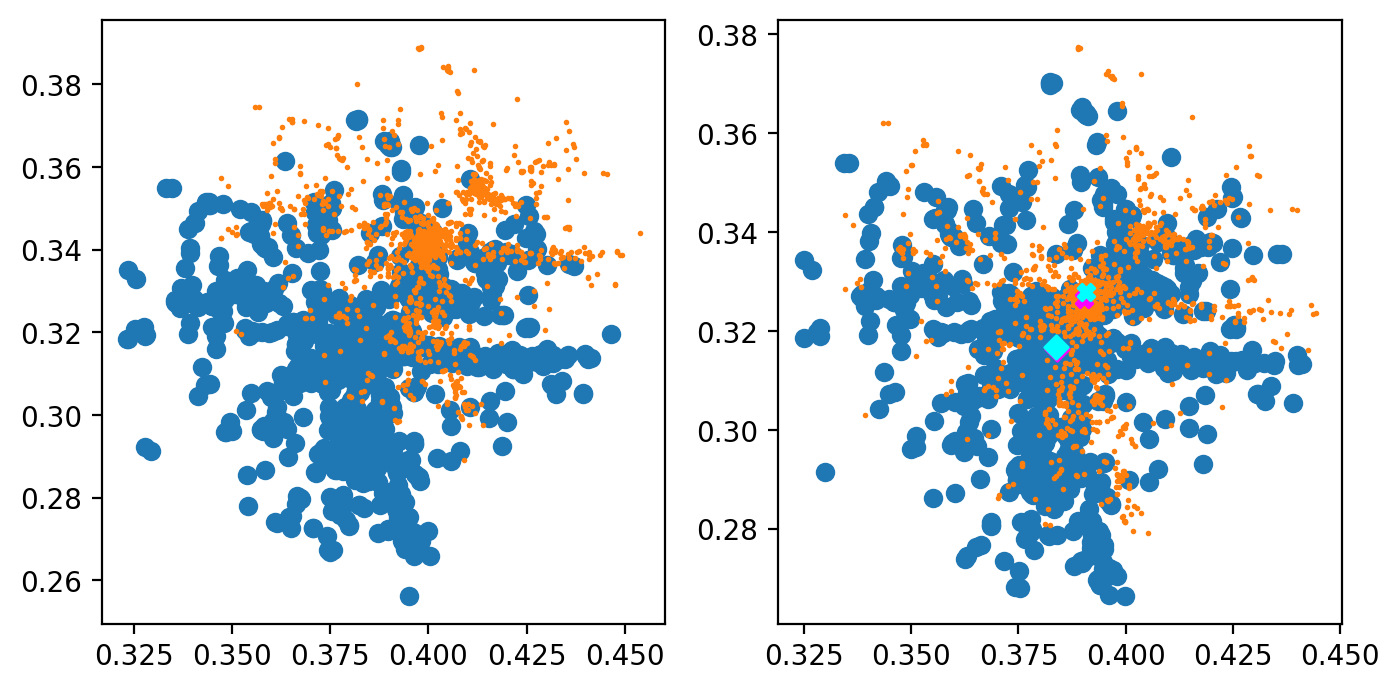

In [396]:
fig, axes = plt.subplots(ncols=2, figsize=(8,4))
fig.set_dpi(200)
aout = 160
asnap = uri.RamsesSnapshot(repo, aout, mode=rurmode)
gals = uhmi.HaloMaker.load(asnap, galaxy=True)
ax = axes[0]
ax.scatter(gals['x'], gals['y'])
ax.scatter(acorr(gals['x'], asnap.params['aexp']), acorr(gals['y'], asnap.params['aexp']), s=1)

aout = 176
asnap = uri.RamsesSnapshot(repo, aout, mode=rurmode)
gals = uhmi.HaloMaker.load(asnap, galaxy=True)
ax = axes[1]
ax.scatter(gals['x'], gals['y'])
ax.scatter(acorr(gals['x'], asnap.params['aexp']), acorr(gals['y'], asnap.params['aexp']), s=1)
target = gals[1229-1]
vel = jn.rms(target['vx'], target['vy'], target['vz'])
agx = acorr(target['x'], asnap.params['aexp'])
agy = acorr(target['y'], asnap.params['aexp'])
agz = acorr(target['z'], asnap.params['aexp'])
ax.scatter(target['x'], target['y'], marker='D', color='magenta')
ax.scatter(agx, agy, marker='X', color='magenta')

bout = 175
bsnap = uri.RamsesSnapshot(repo, bout, mode=rurmode)
bgals = uhmi.HaloMaker.load(bsnap, galaxy=True)
btarget = bgals[1225-1]
bgx = acorr(btarget['x'], bsnap.params['aexp'])
bgy = acorr(btarget['y'], bsnap.params['aexp'])
bgz = acorr(btarget['z'], bsnap.params['aexp'])
ax.scatter(btarget['x'], btarget['y'], marker='D', color='cyan')
ax.scatter(bgx, bgy, marker='X', color='cyan')

dt = np.abs( asnap.params['age'] - bsnap.params['age'] )
dt *= 1e9 * 365 * 24 * 60 * 60 # Gyr to sec
dist0 = dt*vel*asnap.unit['km']
dist1 = jn.distance(target, btarget)
dist2 = jn.distance(agx,agy,agz,bgx,bgy,bgz)
print(dist0)
print(dist1, dist2)

# ax.scatter(gals['x'], gals['y'])
# ax.scatter(acorr(gals['x'], bsnap.params['aexp']), acorr(gals['y'], bsnap.params['aexp']), s=1)
# target = gals[0]
# ax.scatter(target['x'], target['y'], marker='D', color='magenta')
# ax.scatter(acorr(target['x'], bsnap.params['aexp']), acorr(target['y'], bsnap.params['aexp']), marker='X', color='magenta')

# aout = 21
# asnap = uri.RamsesSnapshot(repo, aout, mode=rurmode)
# gals = uhmi.HaloMaker.load(asnap, galaxy=True)
# ax = axes[1]
# ax.scatter(gals['x'], gals['y'])
# ax.scatter(acorr(gals['x'], asnap.params['aexp']), acorr(gals['y'], asnap.params['aexp']), s=1)
# target = gals[0]
# ax.scatter(target['x'], target['y'], marker='D', color='magenta')
# ax.scatter(acorr(target['x'], asnap.params['aexp']), acorr(target['y'], asnap.params['aexp']), marker='X', color='magenta')


In [397]:
target
print(target)
print(target['id'], target['timestep'], target['m'])
print( target['x'], target['y'], target['z'] )
print( target['vx'], target['vy'], target['vz'] )

(9426, 1229, 176, 2, 1, 1, 0, 1230, 0.945, 4.4017505e+09, 0.3840044, 0.31636798, 0.33825013, 689.708, -1444.195, -320.97238, 9.3104864e+08, -1.3957506e+08, 1.0750406e+09, 6.743598e-05, 0.00324881, 0.0044124, 0.00369929, 10903.674, -66.12545, 10837.549, 8.508738, 476.47546, 510.5154, 0.02440106, 5.951431e-05, 4.4017505e+09, 42538.17, 34.42248, 858.784, 5.951431e-05)
1229 176 4401750500.0
0.3840044 0.31636798 0.33825013
689.708 -1444.195 -320.97238


In [398]:
for ifat, a,b in zip(fat1s, fat1s['timestep'], fat1s['id']):
    print(a+19,b)
    if a+19 > 170:
        print("\t",ifat['fat1'], ifat['fat2'])
        print("\t",ifat['mfat1'], ifat['mfat2'])
    

187 1277
	 278 0
	 97.909676 1.7321275
186 278
	 323 0
	 94.4005 5.175171
185 323
	 247 0
	 94.29887 5.3342967
184 247
	 191 0
	 94.53514 5.0719223
183 191
	 320 0
	 94.19375 5.4021893
182 320
	 207 0
	 92.35394 7.2292676
181 207
	 1168 0
	 86.89659 6.436153
180 1168
	 1220 1176
	 93.71212 2.1023347
179 1220
	 1219 2
	 83.30153 11.143693
178 1219
	 1218 2
	 93.63588 3.5376859
177 1218
	 1229 1
	 78.26282 20.808321
176 1229
	 1225 2
	 80.88099 18.481915
175 1225
	 1210 1
	 86.99532 12.320979
174 1210
	 1184 0
	 95.98269 1.8967396
173 1184
	 1199 0
	 94.315414 4.2058854
172 1199
	 503 0
	 85.026024 10.934312
171 503
	 349 0
	 97.48514 2.1172907
170 349
169 288
168 343
167 317
166 469
165 312
164 437
163 1421
162 268
161 373
160 280
159 379
158 1298
157 1333
156 1334
155 1326
154 1325
153 396
152 381
151 430
150 373
149 282
148 314
147 386
146 364
145 84
144 222
143 187
142 1459
141 1480
140 198
139 1417
138 275
137 279
136 281
135 217
134 513
133 502
132 553
131 224
130 373
129 1603
128 